<font size="+1"> <b>Load data with NeuroPyxels </b> </font>

Github repo: https://github.com/m-beau/NeuroPyxels

#### Imports

In [12]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# Ensures that npyx will ACTUALLY be reimported in a running session
%reload_ext autoreload
%autoreload 2
from npyx import *

## 1 - Loading Neuropixels data

First, fill in the path to your spike-sorted Neuropixels dataset (e.g. sorted with kilosort and curated with phy)

BASE_PATH stands for datapath to folder containing: *imec0.bin, *imec0.meta, and kilosort output files from imec_specs

In [2]:
BASE_PATH = "./../" 

### 1.1 - Load Neuropixels sync channel, metadata

In [6]:
# Threshold crosses of the sync channel acquired with the SMA port on the acquisition board
onsets, offsets = get_npix_sync(BASE_PATH)
onsets

{6: array([5.31900000e-01, 1.68020000e+00, 2.92950000e+00, ...,
        1.24071540e+03, 1.24152067e+03, 1.24207597e+03])}

In [3]:
# blah.ap.meta file contents and more
meta = read_metadata(BASE_PATH)
print(f"Neuropixels probe {meta['probe_version']} acquired with {meta['acquisition_software']}.")
fs = meta['highpass']['sampling_rate']
print(f"Highpass filtered data at {meta['highpass']['binary_relative_path']} was acquired at {fs} Hz.")

Neuropixels probe 1.0 acquired with SpikeGLX.
Highpass filtered data at ./s1_1835_light_intermediate_g0_t0.imec0.ap.bin was acquired at 30000 Hz.


### 1.2 Load units and unit qualities (good, mua, noise...)

In [5]:
all_units = get_units(BASE_PATH,f="cluster_KSLabel.tsv", group_col="KSLabel")
good_units = get_units(BASE_PATH, quality="good",f="cluster_KSLabel.tsv", group_col="KSLabel")
print (f"total units in data: {len(all_units)}, of which good units identified: {len(good_units)}")

total units in data: 540, of which good units identified: 278


### 1.3 - Load spike trains

In [ ]:
# pick unit
u = good_units[1]

# Load spikes 
t = trn(BASE_PATH, u) # t: spike times for unit 'u' in samples
print(f"Neuron {u} has {t.shape[0]} spikes across 4 sessions")
t = t / fs # convert from samples to seconds

In [14]:
# Plot (only subset of all spikes specified in 'xlim' below)
plt.scatter(t, t*0, marker="|")
fig = mplp(xlim = [0,1], ylabel = f"Spikes of neuron {u}\n between 0 and 1s", xlabel = "Time (s)")
fig[0].show()

In [123]:
print (f"top 10 spikes times(s) of unit {u}:\n{list(t[:10])}")

top 10 spikes times(s) of unit 1:
[0.12576666666666667, 0.28203333333333336, 0.334, 0.3888666666666667, 0.4204, 0.4444, 0.5072666666666666, 0.6072, 0.9336666666666666, 1.2122666666666666]


### 1.4 - Load spike waveforms

In [15]:
# load waveform
# it loads waveforms from raw data file (*.bin) from 'BASE_PATH' folder path. If you want to load for all sessions, 
# make sure the '*.bin' is the concatenated file from all sessions (s1,s2,s3,s4). 
waveforms = wvf(BASE_PATH, 3, t_waveforms=82) # t_waveforms: temporal span of waveforms | Default 82 (about 3ms)
spikes, samples, channels = waveforms.shape
print(f"wvf() returns an array of shape {spikes} spikes by {samples} samples (time) by {channels} channels.")

# Find peak channel
peak_channel = waveforms.mean(0).max(0).argmax()
print(f"We define the peak channel as the channel with maximum amplitude: here {peak_channel}")

# Plot
w_time = np.arange(samples) * 1000 / fs
w = waveforms.mean(0)[:,peak_channel]
w_s = waveforms.std(0)[:,peak_channel]
plt.fill_between(w_time, w+w_s, w-w_s, alpha=0.4)
plt.plot(w_time, w, color="k")
fig = mplp(title = f"Unit {u} peaking on channel {peak_channel}", xlabel = "Time (ms)", ylabel = "Voltage (uV)")

wvf() returns an array of shape 100 spikes by 82 samples (time) by 384 channels.
We define the peak channel as the channel with maximum amplitude: here 1


In [17]:
waveforms.shape

(100, 82, 384)

### Or you can directly plot them, according to your probe's channel map:

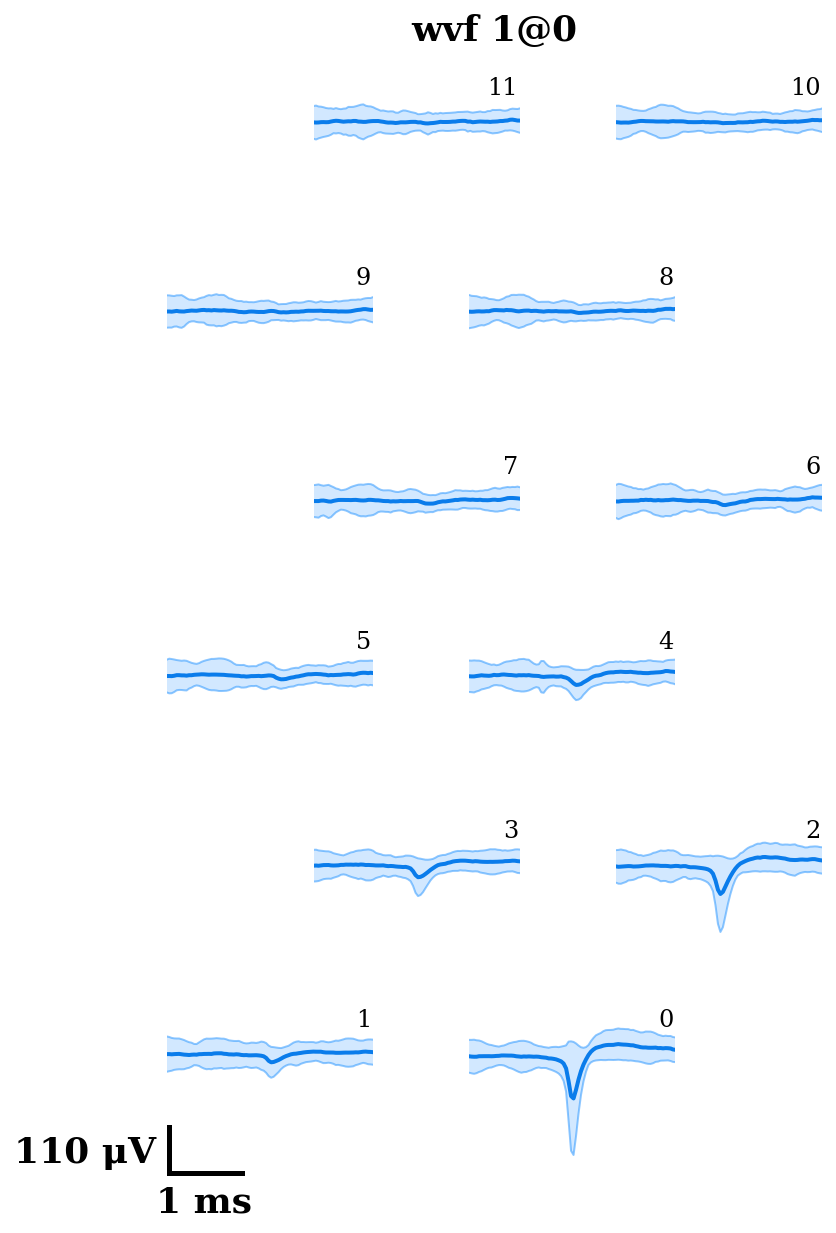

In [108]:
# it will find the peak channel by itself
fig = plot_wvf(BASE_PATH, u, Nchannels=12,t_waveforms=2.8,)

### 1.5 Load raw data

extract_rawChunk() function return the raw traces for specified time intervals across all channels. It has additional preprocessing arguments, see function definition below:

*location of this function: 'NeuroPyxels-master/npyx/inout.py'

**def extract_rawChunk** *(BASE_PATH, times, channels=np.arange(384), filt_key='highpass', save=0,
                     whiten=0, med_sub=0, hpfilt=0, hpfiltf=300, filter_forward=True, filter_backward=True,
                     nRangeWhiten=None, nRangeMedSub=None, use_ks_w_matrix=True,
                     ignore_ks_chanfilt=True, center_chans_on_0=False, verbose=False, scale=True, again=False):* 
                     
    '''Function to extract a chunk of raw data on a given range of channels on a given time window.
    Arguments:
    - BASE_PATH: datapath to folder with binary path (files must ends in .bin, typically ap.bin)
    - times: list of boundaries of the time window, in seconds [t1, t2].
    - channels (default: np.arange(384)): list of channels of interest, in 0 indexed integers [c1, c2, c3...]
    - filt_key: 'ap' or 'lf', whether to exxtract from the high-pass or low-pass filtered binary file
    - save (default 0): save the raw chunk in the bBASE_PATH directory as '{bBASE_PATH}_t1-t2_c1-c2.npy'
    - whiten: whether to whiten the data across channels. If nRangeWhiten is not None,
              whitening matrix is computed with the nRangeWhiten closest channels.
    - med_sub: whether to median-subtract the data across channels. If nRangeMedSub is not none,
               median of each channel is computed using the nRangeMedSub closest channels.
    - hpfilt: whether to high-pass filter the data, using a 3 nodes butterworth filter of cutoff frequency hpfiltf, bidirectionally.
    - hpfiltf: see hpfilt
    - filter_forward: bool, filter the data forward (also set filter_backward to True for bidirectional filtering)
    - filter_backward: bool, filter the data backward (also set filter_forward to True for bidirectional filtering)
    - nRangeWhiten: int, see whiten.
    - nRangeMedSub: int, see med_sub.
    - use_ks_w_matrix: bool, whether to use kilosort's original whitening matrix to perform the whitening
                     (rather than recomputing it from the data at hand)
    - ignore_ks_chanfilt: whether to ignore the filtering made by kilosort,
                          which only uses channels with average events rate > ops.minfr to spike sort.
    - scale: A boolean variable specifying whether we should convert the resulting raw
             A2D samples to uV. Defaults to True
    Returns:
    - rawChunk: numpy array of shape ((c2-c1), (t2-t1)*fs).
                rawChunk[0,:] is channel 0; rawChunk[1,:] is channel 1, etc.
                dtype: int16 if scale=False, float64 if scale=True.

In [124]:
# Load raw data
times=[0, 0.07] #specify times in seconds
raw_data_chunk = extract_rawChunk(BASE_PATH, times)
channels, samples = raw_data_chunk.shape

extract_rawChunk() returns an array of shape 384 channels x 2100 samples (70ms)


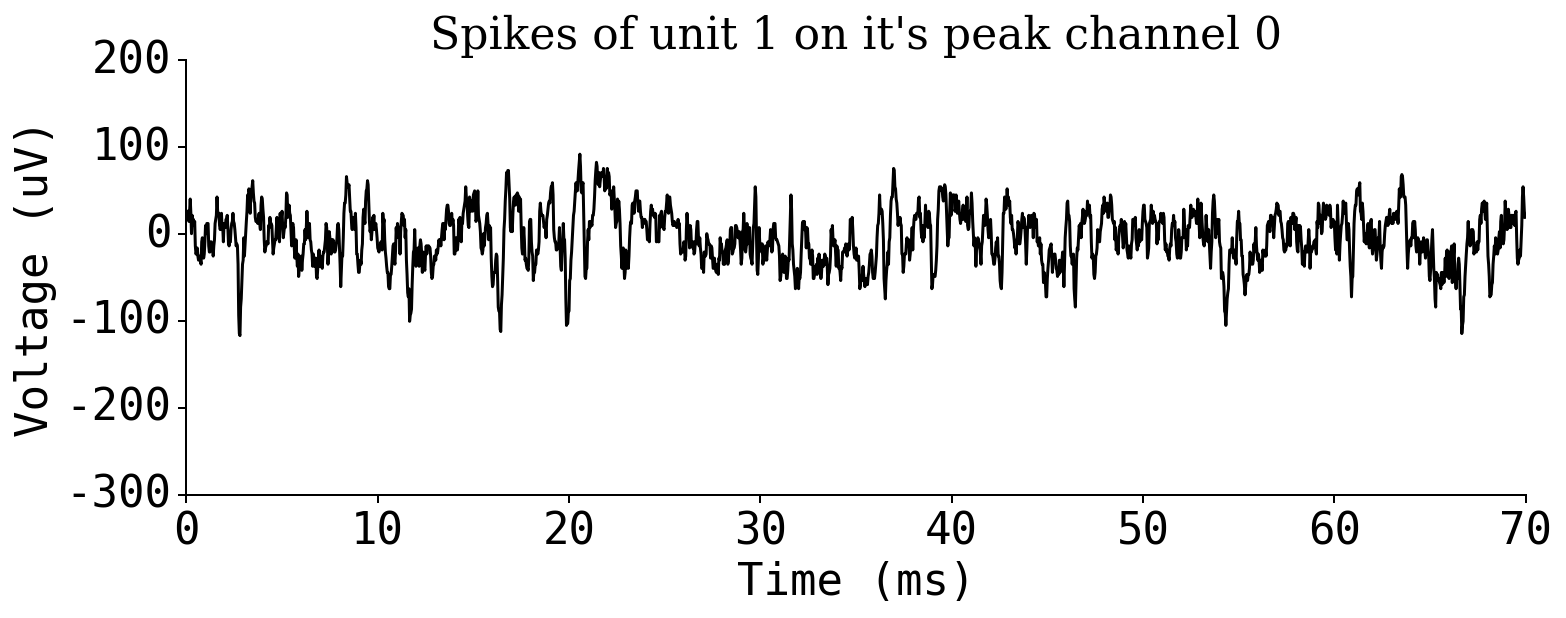

In [81]:
print(f"extract_rawChunk() returns an array of shape {channels} channels x {samples} samples ({round(samples/30)}ms)")
plt.plot(np.arange(samples)/30, raw_data_chunk[peak_channel], color='k')
plt.scatter(t* 1000, t * 0 - 250, color="red", marker="^", lw=3, s=20)
fig = mplp(figsize = (12,4), title = f"Spikes of unit {u} on it's peak channel {peak_channel}", xlim = [0, samples * 1000 / fs], ylim = [-300, 200],
           xlabel = "Time (ms)", ylabel = "Voltage (uV)")

### or you can directly overlay the spikes of one or several unit on the raw data!

plotting unit 1...
plotting spike 1/1...  

plotting unit 4...
plotting spike 1/4...  plotting spike 2/4...  plotting spike 3/4...  plotting spike 4/4...  



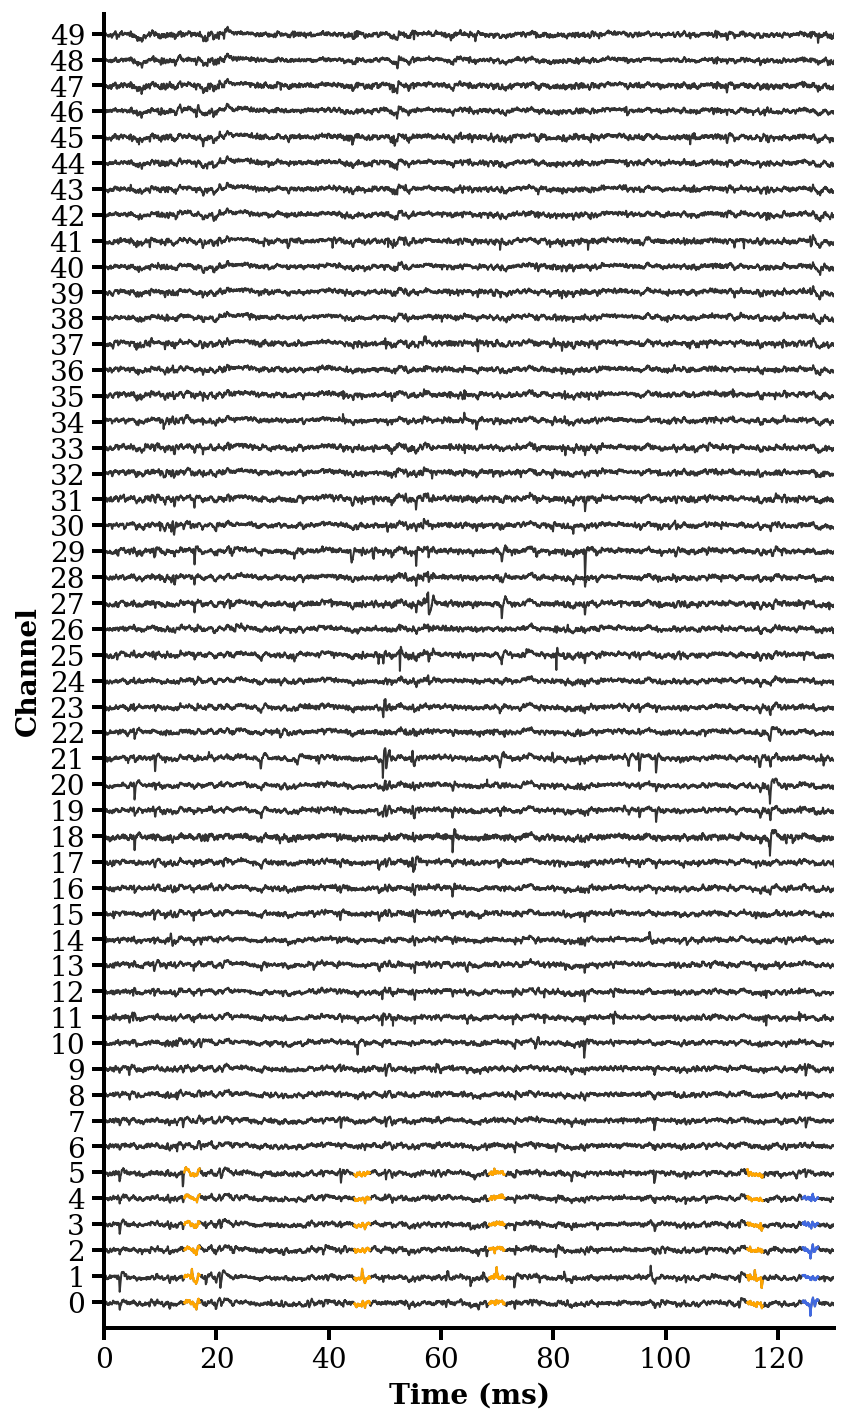

In [118]:
fig = plot_raw_units(BASE_PATH, times=[0,0.13], units = [u,good_units[3]], channels = np.arange(50),
               colors=['royalblue','orange'], yticks_jump = 1, figsize=(6,10),
               offset=450,  Nchan_plot=10)

## 2 - Processing Neuropixels data

### 2.1 - Raw data preprocessing

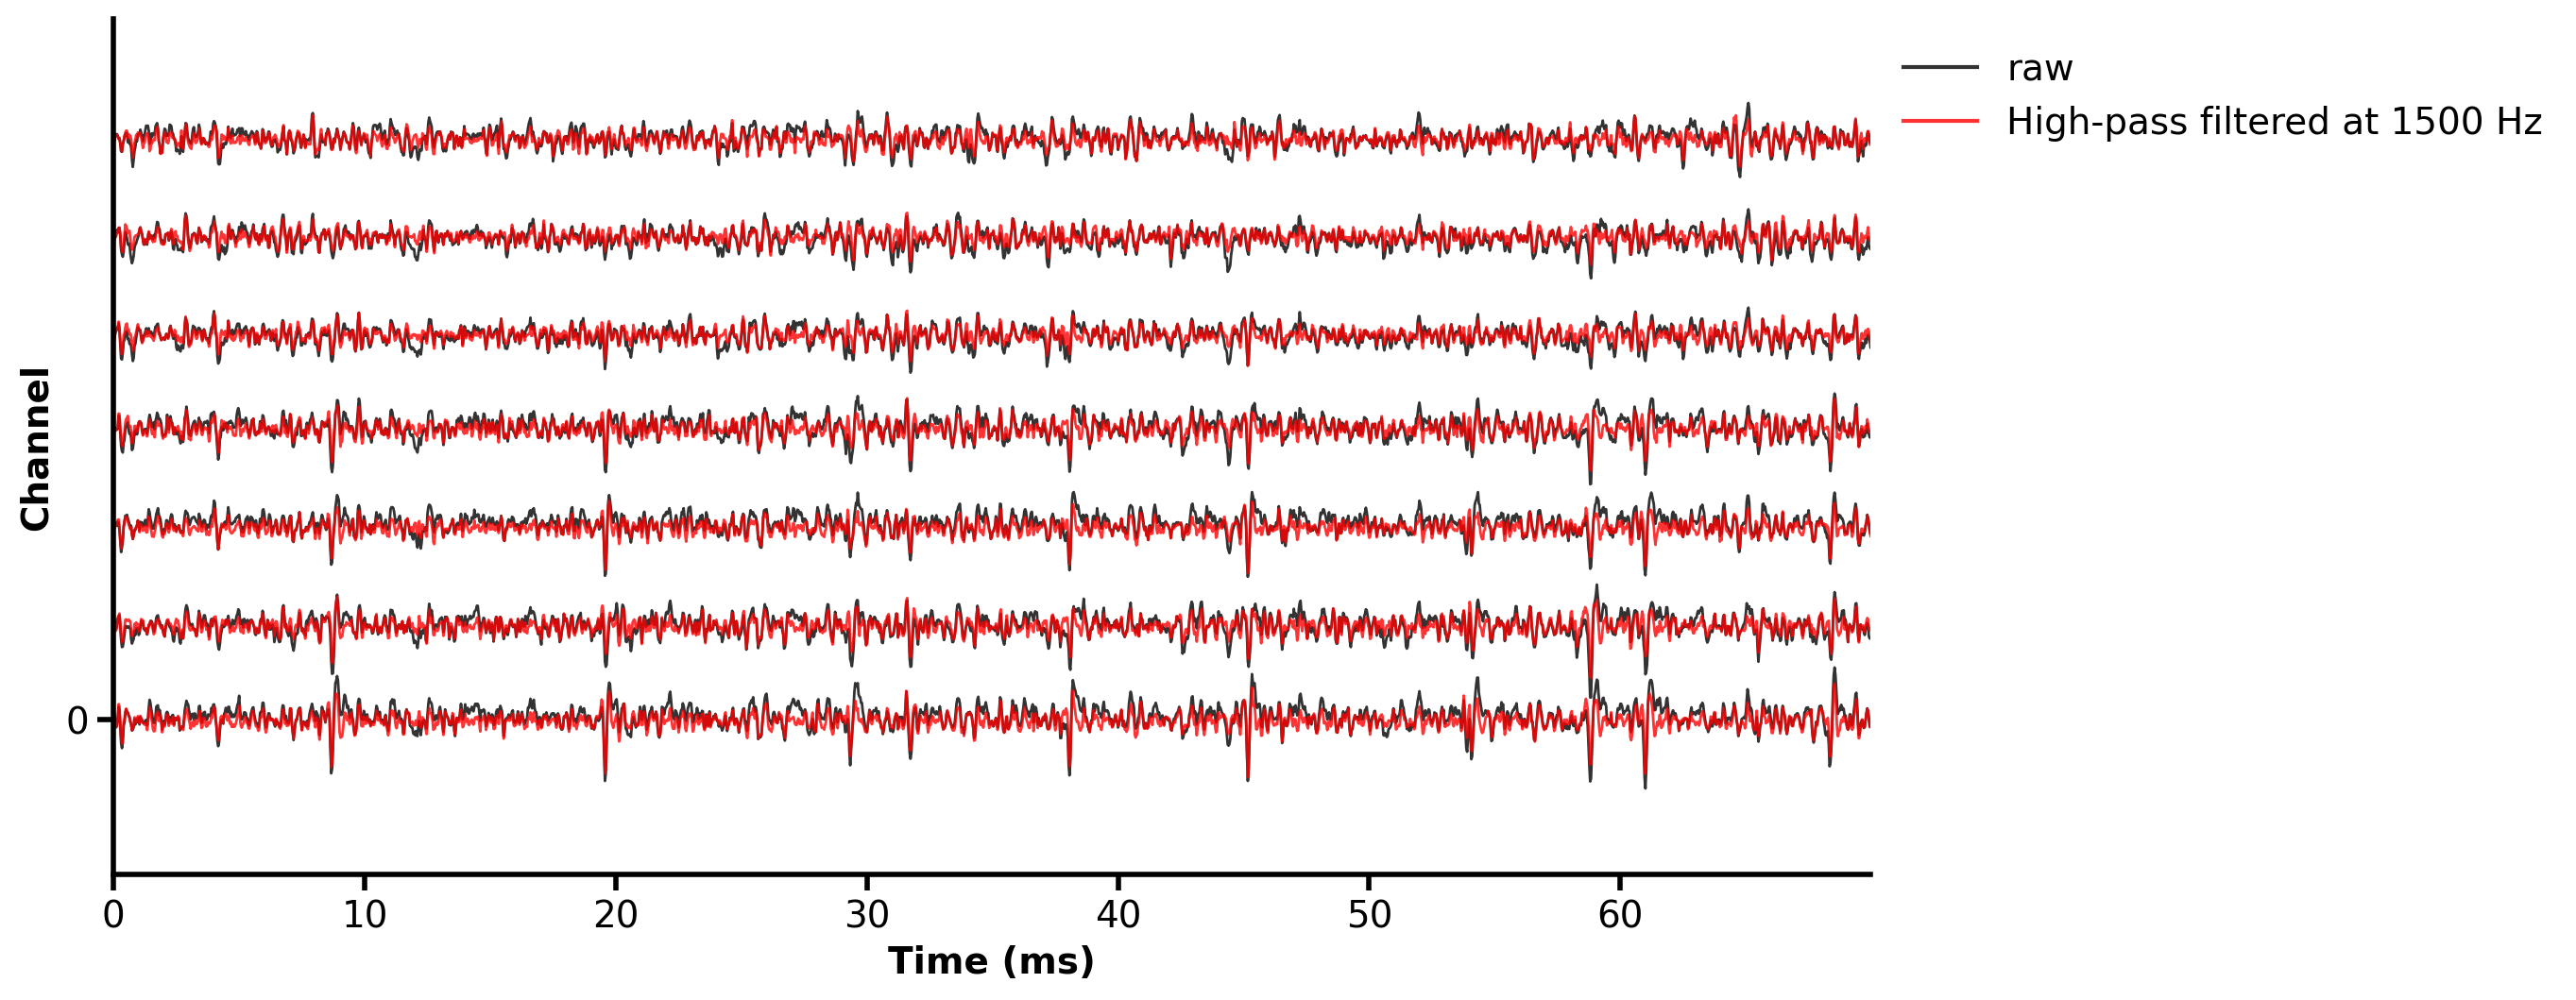

In [36]:
fig = plot_raw(BASE_PATH, times=[0,0.07], channels = np.arange(7),
               yticks_jump = 1, figsize=(12,6), legend="raw")
fig = plot_raw(BASE_PATH, times=[0,0.07], channels = np.arange(7),
               
               whiten=False, med_sub=False, hpfilt=True, hpfiltf=1500, nRangeWhiten=None, nRangeMedSub=None, use_ks_w_matrix=False, # <<<<<
               
               color = 'red', ax = fig.get_axes()[0], legend="High-pass filtered at 1500 Hz")